In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np

DataFrame函數



df.head()   #顯示前五筆資料

df.tail()   #顯示後五筆資料

df.info()   #顯示欄位型別與缺漏值

df.dropna() #移除缺失值列（NaN）

df.fillna(0)#把NaN補0

In [4]:
file_path = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-smoothed-2025-07-07-16-47-35.tsv"
#使用pandas的read_csv讀取tsv檔案,作為一個資料表(dataframe)
#sep="\t"表示分隔符號是tab鍵,skiprows=5表示跳過前5行
df = pd.read_csv(file_path, sep="\t", skiprows=5)

In [5]:
#清理欄位的名字
#df.columns是指欄位名稱的列表
#每個欄位名稱都去除前後空白和#符號
df.columns = [col.strip().lstrip('#').strip() for col in df.columns]

In [6]:
#確保兩欄都是數值
#pd.to_numeric是將欄位轉換為數值型態(float或int)
#errors="coerce"表示如果轉換失敗，則將該值設為NaN
df[df.columns[0]] = pd.to_numeric(df[df.columns[0]], errors="coerce")
df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors="coerce")

#刪除任何包含NaN的行
df = df.dropna()

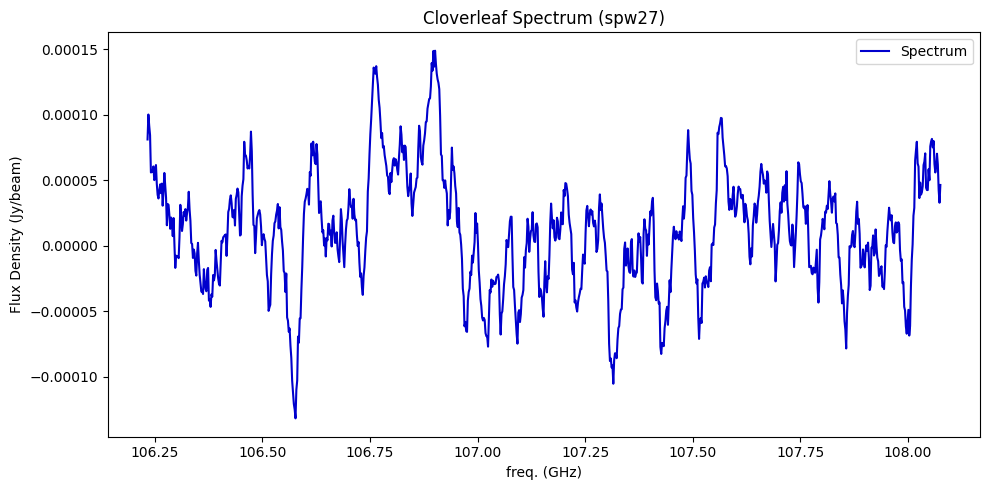

In [7]:
#先畫一個沒平滑過的
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Spectrum", color="mediumblue")
plt.xlabel("freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Cloverleaf Spectrum (spw27)")
plt.grid(False)
plt.legend()      #圖例
plt.tight_layout()#自動排版
plt.show()

In [8]:
#平滑（高斯濾波,12個sigma）
y_smoothed = gaussian_filter1d(df[df.columns[1]], sigma=12)

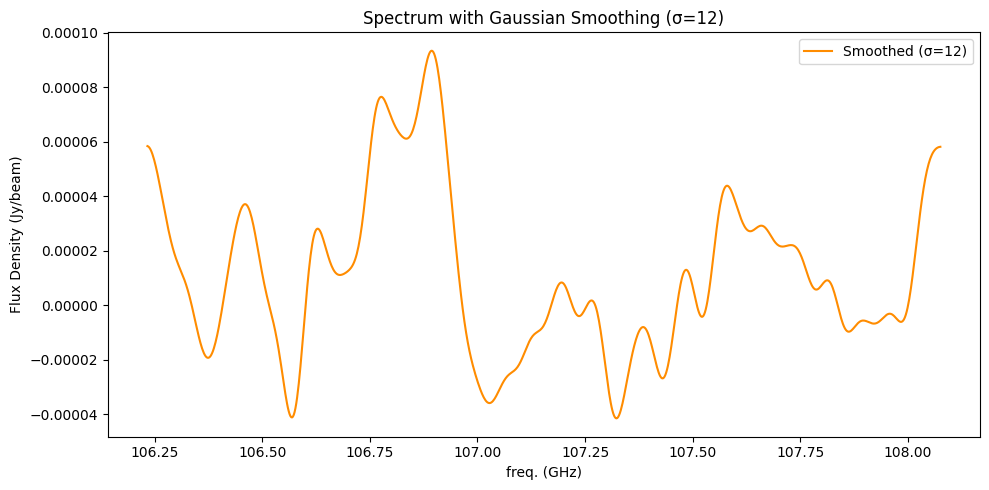

In [9]:
plt.figure(figsize=(10, 5))
#plt.plot(df[df.columns[0]], df[df.columns[1]], label="Original Spectrum", color="mediumblue", alpha=0.5)
plt.plot(df[df.columns[0]], y_smoothed, label="Smoothed (σ=12)", color="darkorange")
plt.xlabel("freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum with Gaussian Smoothing (σ=12)")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
#加入譜線(沒存到HAHA)
#line_file = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-2025-07-07-16-47-35.tsv.tsv"
#df_lines = pd.read_csv(file_path, sep="\t", skiprows=5)
#df_lines.columns = [col.strip().lstrip('#').strip() for col in df_lines.columns]
#line_positions = pd.to_numeric(df_lines[df_lines.columns[0]], errors="coerce").dropna()

#換成手打   (freq, label)
my_lines = [(106.857,"H2O")]

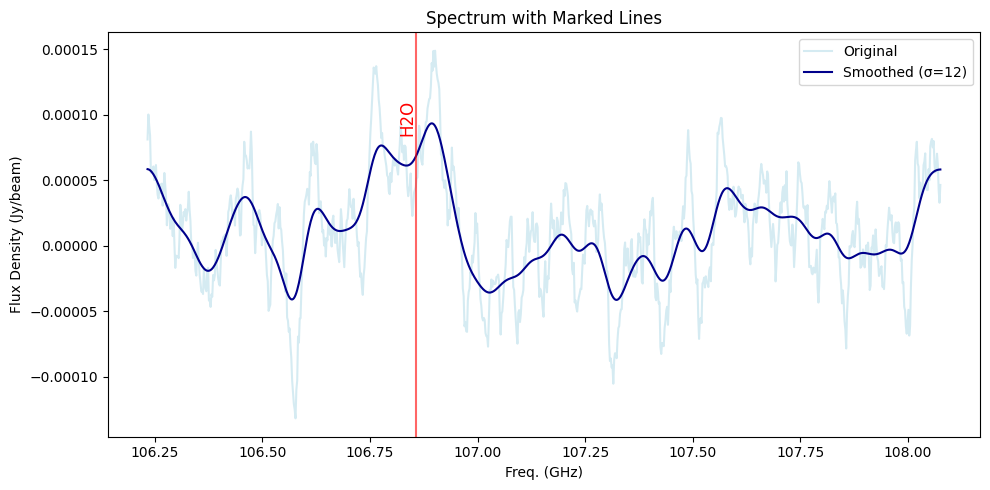

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Original", color="lightblue", alpha=0.5)
plt.plot(df[df.columns[0]], y_smoothed, label="Smoothed (σ=12)", color="darkblue")
for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_smoothed)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='bottom')
plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum with Marked Lines")
plt.legend()
plt.tight_layout()
plt.show()


測試拉，不知道可不可以成功

In [18]:
#binning smoothing
def rebin_spectrum(x, y, bin_size):
    n_bins = len(y) // bin_size
    x = x[:n_bins * bin_size]
    y = y[:n_bins * bin_size]
    x_binned = x.reshape(n_bins, bin_size).mean(axis=1)
    y_binned = y.reshape(n_bins, bin_size).mean(axis=1)
    return x_binned, y_binned

x_bin, y_bin = rebin_spectrum(x, y, bin_size=10)

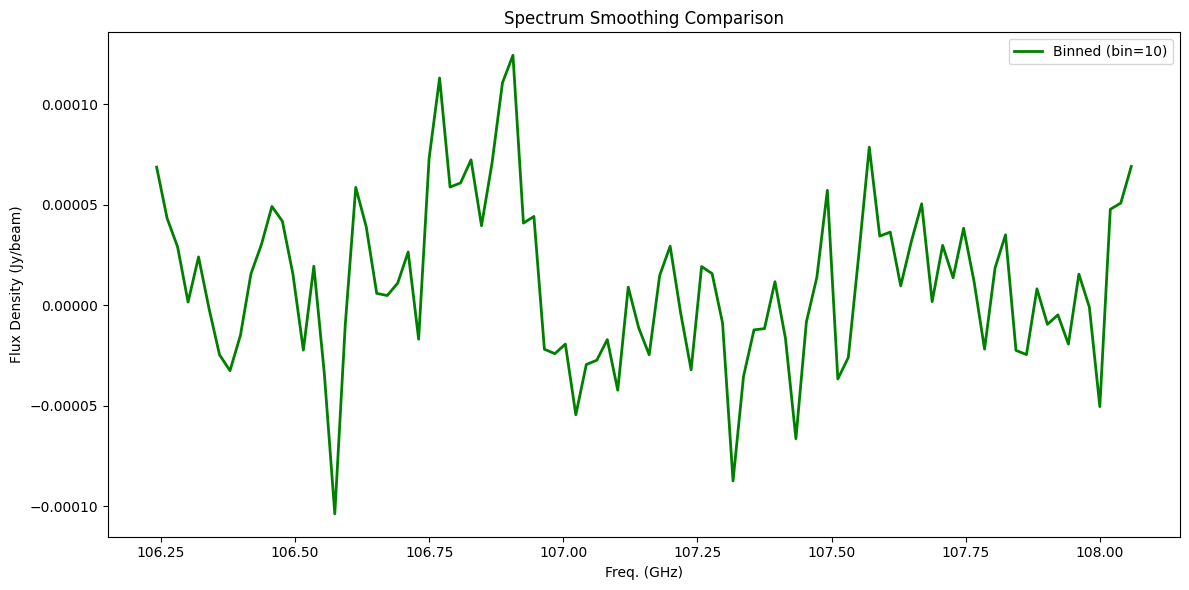

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(x_bin, y_bin, label="Binned (bin=10)", color="green", linewidth=2)

plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#boxcar smoothing
def boxcar_smooth(y, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(y, kernel, mode='same')

y_boxcar = boxcar_smooth(y, kernel_size=30)



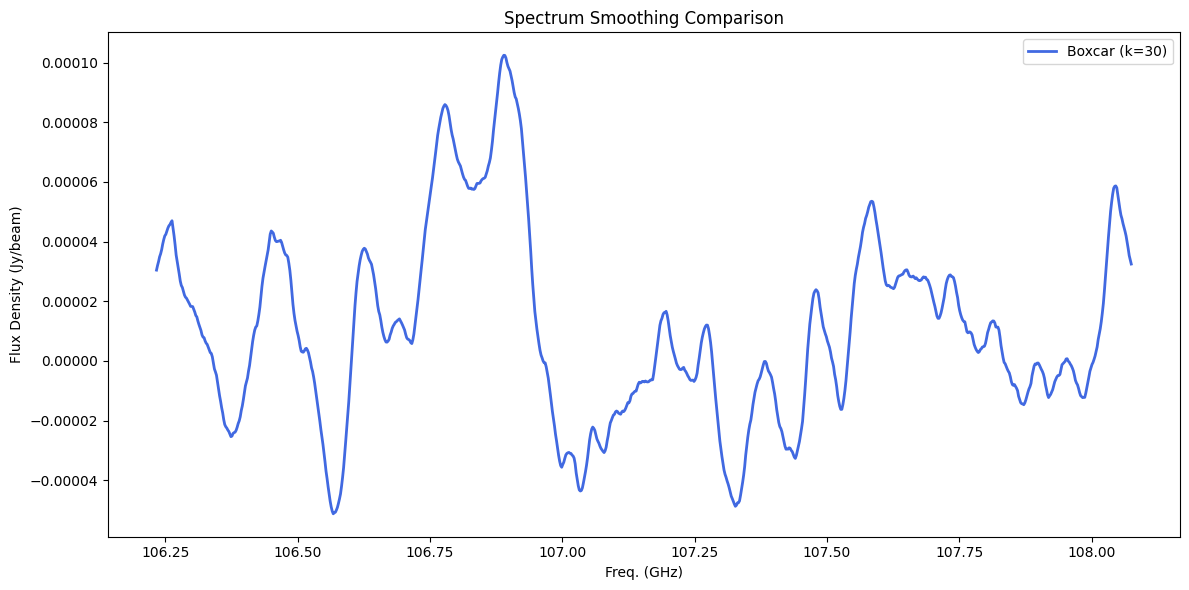

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(x, y_boxcar, label="Boxcar (k=30)", color="royalblue", linewidth=2)
plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()

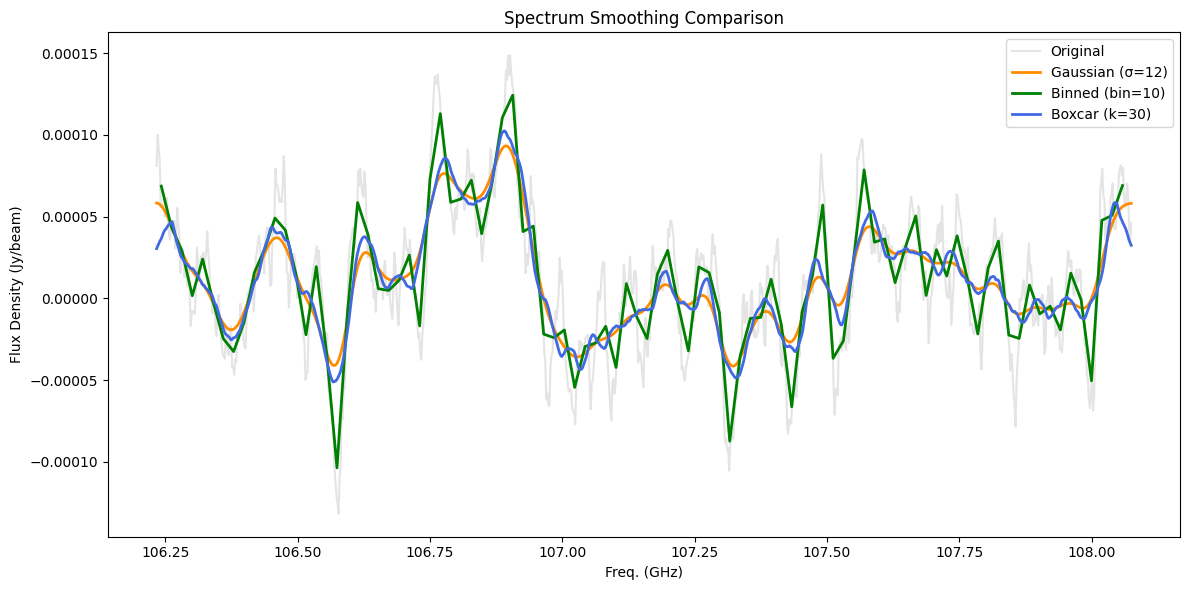

In [26]:
# 比較看看吧
plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Original", color="lightgray", alpha=0.6)
plt.plot(x, y_gauss, label="Gaussian (σ=12)", color="darkorange", linewidth=2)
plt.plot(x_bin, y_bin, label="Binned (bin=10)", color="green", linewidth=2)
plt.plot(x, y_boxcar, label="Boxcar (k=30)", color="royalblue", linewidth=2)

plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()